# BioKGBench: Evaluating LLMs for Biomedical Knowledge Graph Question Answering

## ISMB 2026 Tutorial

---

### Authors
**KAUST Computational Bioscience Research Center (CBRC)**

---

### Abstract

This tutorial demonstrates how to evaluate Large Language Models (LLMs) on the **BioKGBench** benchmark for Knowledge Graph Question Answering (KGQA) in the biomedical domain. We compare 8 state-of-the-art LLMs including GPT-4, Claude-3, DeepSeek-V3, Llama-3.1, and Qwen-2.5 on their ability to:

1. **Understand** natural language biomedical questions
2. **Generate** accurate Cypher queries for Neo4j knowledge graphs
3. **Retrieve** correct answers from complex multi-hop reasoning paths

### Learning Objectives

By the end of this tutorial, you will be able to:
- Load and explore the BioKGBench dataset
- Understand KGQA evaluation metrics (F1, EM, Hits@K, MRR)
- Compare LLM performance across different question types
- Run your own evaluations on new models

---

### Table of Contents

1. [Environment Setup](#1-environment-setup)
2. [Load BioKGBench Dataset](#2-load-biokgbench-dataset)
3. [Understanding the Data](#3-understanding-the-data)
4. [Evaluation Metrics](#4-evaluation-metrics)
5. [LLM Configuration](#5-llm-configuration)
6. [Load Pre-computed Results](#6-load-pre-computed-results)
7. [Results Visualization](#7-results-visualization)
8. [Performance by Question Type](#8-performance-by-question-type)
9. [Running Custom Evaluations](#9-running-custom-evaluations)
10. [Conclusions](#10-conclusions)

---

## 1. Environment Setup

### Step 1.1: Install Required Packages

Before running this tutorial, ensure you have the following packages installed:

```bash
pip install neo4j openai anthropic huggingface_hub pyyaml tqdm pandas matplotlib seaborn
```

### Step 1.2: Import Libraries

In [19]:
# =============================================================================
# STEP 1.2: Import Required Libraries
# =============================================================================
# These libraries are essential for:
# - json, yaml: Configuration and data loading
# - pandas: Data manipulation and analysis
# - matplotlib, seaborn: Visualization
# - tqdm: Progress bars for long-running operations
# - huggingface_hub: Download benchmark dataset
# =============================================================================

import json
import os
import sys
import yaml
import time
import glob
from datetime import datetime
from collections import defaultdict
from typing import List, Dict, Set, Optional, Tuple

# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm.notebook import tqdm

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*60)
print("BioKGBench Evaluation Tutorial - ISMB 2026")
print("="*60)
print(f"Python version: {sys.version.split()[0]}")
print("All required libraries loaded successfully!")

BioKGBench Evaluation Tutorial - ISMB 2026
Python version: 3.10.13
All required libraries loaded successfully!


### Step 1.3: Configure Working Directory

Set up the working directory and add necessary paths for importing local modules.

In [20]:
# =============================================================================
# STEP 1.3: Configure Working Directory
# =============================================================================
# The benchmark directory contains:
# - src/kg_qa_system_v2.py: Main KGQA system implementation
# - src/llm_client.py: LLM API clients (OpenAI, Claude, Together AI)
# - config/config.yaml: Configuration for Neo4j and LLM settings
# - results/eval_results_*.json: Pre-computed evaluation results
# =============================================================================
from pathlib import Path

# Get the directory where this notebook is located
NOTEBOOK_DIR = Path.cwd()

# Detect project structure - handle running from tutorials/ or benchmark root
if NOTEBOOK_DIR.name == 'tutorials':
    BENCHMARK_DIR = NOTEBOOK_DIR.parent
elif 'BioKGBench' in str(NOTEBOOK_DIR):
    BENCHMARK_DIR = NOTEBOOK_DIR
else:
    # Fallback: assume we're somewhere in the project
    BENCHMARK_DIR = Path('/ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench')

# Key directories
SRC_DIR = BENCHMARK_DIR / 'src'
RESULTS_DIR = BENCHMARK_DIR / 'results'
CONFIG_DIR = BENCHMARK_DIR / 'config'
DATA_DIR = BENCHMARK_DIR / 'data'

# Add src to Python path for importing local modules
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print(f"Working directory: {NOTEBOOK_DIR}")
print(f"Benchmark directory: {BENCHMARK_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print("\nDirectory contents:")
print(f"  - {CONFIG_DIR}/config.local.yaml")
print(f"  - {SRC_DIR}/kg_qa_system_v2.py")
print(f"  - {SRC_DIR}/llm_client.py")
print(f"  - {RESULTS_DIR}/eval_results_*.json")

Working directory: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/tutorials
Benchmark directory: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench
Results directory: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results

Directory contents:
  - /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/config/config.local.yaml
  - /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/src/kg_qa_system_v2.py
  - /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/src/llm_client.py
  - /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/eval_results_*.json


---

## 2. Load BioKGBench Dataset

### About BioKGBench

**BioKGBench** is a comprehensive benchmark for evaluating LLMs on biomedical knowledge graph question answering. The dataset is hosted on HuggingFace and contains:

- **Test set**: 638 questions for final evaluation
- **Dev set**: Smaller set for development and debugging

### Step 2.1: Download Dataset from HuggingFace

In [21]:
# =============================================================================
# STEP 2.1: Download BioKGBench Dataset from HuggingFace
# =============================================================================
# The dataset is automatically cached locally after first download.
# Subsequent runs will use the cached version.
# 
# Dataset repository: AutoLab-Westlake/BioKGBench-Dataset
# Contents:
#   - kgqa/test.json: 638 test questions
#   - kgqa/dev.json: Development questions
# =============================================================================

from huggingface_hub import snapshot_download

print("Downloading BioKGBench dataset from HuggingFace...")

# Download the complete dataset
DATA_PATH = snapshot_download(
    repo_id="AutoLab-Westlake/BioKGBench-Dataset",
    repo_type="dataset"
)

print(f"Dataset location: {DATA_PATH}")
print("Download complete!")

Fetching 96 files:   0%|          | 0/96 [00:00<?, ?it/s]

Dataset location: /home/alsaedsb/.cache/huggingface/hub/datasets--AutoLab-Westlake--BioKGBench-Dataset/snapshots/4d992e7e735d81cb84d02f86f6489c82479c290e
Download complete!


### Step 2.2: Load Test and Dev Sets

In [22]:
# =============================================================================
# STEP 2.2: Load Test and Development Sets
# =============================================================================
# Each question in the dataset contains:
# - 'question': Natural language question text
# - 'type': Question type (one-hop, multi-hop, conjunction)
# - 'answer': List of gold standard answers
# - Additional metadata for query generation
# =============================================================================

# Load the test set (used for final evaluation)
with open(f"{DATA_PATH}/kgqa/test.json", 'r') as f:
    test_data = json.load(f)

# Load the dev set (used for development and quick testing)
with open(f"{DATA_PATH}/kgqa/dev.json", 'r') as f:
    dev_data = json.load(f)

print("="*60)
print("Dataset Statistics")
print("="*60)
print(f"Test set: {len(test_data)} questions")
print(f"Dev set:  {len(dev_data)} questions")
print("="*60)

Dataset Statistics
Test set: 638 questions
Dev set:  60 questions


---

## 3. Understanding the Data

### Step 3.1: Explore Question Types

BioKGBench contains three types of questions:

| Type | Description | Example |
|------|-------------|--------|
| **one-hop** | Single relationship traversal | "What genes are associated with diabetes?" |
| **multi-hop** | Multiple relationship traversals | "What drugs treat diseases caused by gene X?" |
| **conjunction** | Questions requiring AND/OR logic | "Find genes associated with both cancer and heart disease" |

In [23]:
# =============================================================================
# STEP 3.1: Analyze Question Type Distribution
# =============================================================================
# Understanding the distribution helps interpret model performance:
# - one-hop: Simpler queries, higher expected accuracy
# - multi-hop: Complex reasoning, challenging for most LLMs
# - conjunction: Requires combining multiple conditions
# =============================================================================

# Count questions by type
question_types = defaultdict(int)
for q in test_data:
    qtype = q.get('type', 'unknown')
    question_types[qtype] += 1

print("="*60)
print("Question Type Distribution (Test Set)")
print("="*60)
print(f"{'Type':<14} {'Count':>8}    {'Percentage':>10}")
print("-"*60)

for qtype in ['one-hop', 'multi-hop', 'conjunction']:
    count = question_types.get(qtype, 0)
    pct = count / len(test_data) * 100
    print(f"{qtype:<14} {count:>8}       {pct:>5.1f}%")

print("-"*60)
print(f"{'Total':<14} {len(test_data):>8}      {100.0:>5.1f}%")
print("="*60)

Question Type Distribution (Test Set)
Type              Count    Percentage
------------------------------------------------------------
one-hop             355        55.6%
multi-hop           184        28.8%
conjunction          99        15.5%
------------------------------------------------------------
Total               638      100.0%


### Step 3.2: Examine Sample Questions

In [24]:
# =============================================================================
# STEP 3.2: Display Sample Questions from Each Type
# =============================================================================
# This helps understand what the LLM needs to process and the expected
# complexity of Cypher queries that need to be generated.
# =============================================================================

print("="*60)
print("Sample Questions by Type")
print("="*60)

# Find one example of each type
examples = {}
for q in test_data:
    qtype = q.get('type', 'unknown')
    if qtype not in examples:
        examples[qtype] = q
    if len(examples) >= 3:
        break

# Display examples (using placeholder data for demonstration)
print("\n[ONE-HOP EXAMPLE]")
print(f"Question: What genes are associated with breast cancer?")
print(f"Answer: ['BRCA1', 'BRCA2', 'TP53']")

print("\n[MULTI-HOP EXAMPLE]")
print(f"Question: What drugs can treat diseases that gene EGFR is involved in?")
print(f"Answer: ['Gefitinib', 'Erlotinib']")

print("\n[CONJUNCTION EXAMPLE]")
print(f"Question: Find proteins that interact with both TP53 and MDM2.")
print(f"Answer: ['CDKN1A', 'RB1']")
print("="*60)

Sample Questions by Type

[ONE-HOP EXAMPLE]
Question: What genes are associated with breast cancer?
Answer: ['BRCA1', 'BRCA2', 'TP53']

[MULTI-HOP EXAMPLE]
Question: What drugs can treat diseases that gene EGFR is involved in?
Answer: ['Gefitinib', 'Erlotinib']

[CONJUNCTION EXAMPLE]
Question: Find proteins that interact with both TP53 and MDM2.
Answer: ['CDKN1A', 'RB1']


---

## 4. Evaluation Metrics

### Understanding KGQA Metrics

We use standard information retrieval and QA metrics:

| Metric | Formula | Description |
|--------|---------|-------------|
| **F1** | 2×(P×R)/(P+R) | Harmonic mean of precision and recall |
| **EM** | match ∈ {0,1} | Exact match (any prediction matches gold) |
| **Hits@K** | correct in top-K | Whether correct answer appears in top K |
| **MRR** | 1/rank | Mean Reciprocal Rank |
| **Executability** | success/total | % of queries that execute without error |
| **Coverage** | answered/total | % of questions with non-empty answers |

### Step 4.1: Implement Metric Functions

In [25]:
# =============================================================================
# STEP 4.1: Define Core Metric Functions
# =============================================================================
# These functions implement the standard evaluation metrics.
# Partial matching (substring containment) is used to handle:
# - Different entity name formats (e.g., "TP53" vs "Tumor Protein P53")
# - Case variations
# - Minor formatting differences
# =============================================================================

def normalize_answer(answer: str) -> str:
    """
    Normalize an answer string for fair comparison.
    
    Args:
        answer: Raw answer string
        
    Returns:
        Lowercase, stripped string
    """
    if answer is None:
        return ""
    return str(answer).strip().lower()


def extract_gold_answers(gold: List) -> Set[str]:
    """
    Extract normalized gold answers from various input formats.
    
    The gold answers can come in different formats:
    - List of strings: ['answer1', 'answer2']
    - List of dicts: [{'answer': 'x', 'id': 'y'}, ...]
    
    Args:
        gold: List of gold answers in any supported format
        
    Returns:
        Set of normalized answer strings
    """
    answers = set()
    for item in gold:
        if isinstance(item, dict):
            # Extract from dict format
            for key in ['answer', 'id', 'name']:
                if key in item and item[key]:
                    answers.add(normalize_answer(item[key]))
        elif isinstance(item, str):
            answers.add(normalize_answer(item))
    return answers


def compute_f1(predicted_set: Set[str], gold_set: Set[str]) -> float:
    """
    Compute F1 score with partial matching.
    
    F1 = 2 * (precision * recall) / (precision + recall)
    
    Partial matching: A prediction matches if it equals a gold answer
    OR is a substring of it OR contains it.
    
    Args:
        predicted_set: Set of predicted answers
        gold_set: Set of gold answers
        
    Returns:
        F1 score between 0 and 1
    """
    if not predicted_set or not gold_set:
        return 0.0
    
    # Count matches using partial matching
    matches = 0
    for pred in predicted_set:
        for gold in gold_set:
            if pred == gold or pred in gold or gold in pred:
                matches += 1
                break
    
    precision = matches / len(predicted_set) if predicted_set else 0
    recall = matches / len(gold_set) if gold_set else 0
    
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def compute_exact_match(predicted_set: Set[str], gold_set: Set[str]) -> bool:
    """
    Check if ANY predicted answer matches ANY gold answer.
    
    Args:
        predicted_set: Set of predicted answers
        gold_set: Set of gold answers
        
    Returns:
        True if at least one match exists
    """
    if not predicted_set or not gold_set:
        return False
    
    for pred in predicted_set:
        if pred in gold_set:
            return True
        for gold in gold_set:
            if pred in gold or gold in pred:
                return True
    return False


print("Metric functions defined:")
print("  - normalize_answer(): Normalize text for comparison")
print("  - extract_gold_answers(): Extract answers from various formats")
print("  - compute_f1(): Calculate F1 score")
print("  - compute_exact_match(): Check for exact match")

Metric functions defined:
  - normalize_answer(): Normalize text for comparison
  - extract_gold_answers(): Extract answers from various formats
  - compute_f1(): Calculate F1 score
  - compute_exact_match(): Check for exact match


### Step 4.2: Implement Complete Metrics Calculation

In [26]:
# =============================================================================
# STEP 4.2: Comprehensive Metrics Calculation Function
# =============================================================================
# This function processes all predictions and computes:
# 1. Overall metrics across all questions
# 2. Per-type metrics for detailed analysis
# =============================================================================

def compute_metrics(results: List[Dict]) -> Dict:
    """
    Compute all evaluation metrics from prediction results.
    
    Args:
        results: List of result dictionaries, each containing:
            - success: bool - whether query executed successfully
            - predicted: list - predicted answer strings
            - gold_answers: set - gold answer strings
            - question_type: str - type of question
    
    Returns:
        Dictionary containing all metrics and per-type breakdown
    """
    total = len(results)
    hits_1 = hits_5 = hits_10 = 0
    mrr_sum = f1_sum = 0.0
    answered = em_count = executable_count = 0

    # Track metrics by question type
    by_type = defaultdict(lambda: {
        'total': 0, 'answered': 0, 'hits_1': 0, 'hits_5': 0, 'hits_10': 0,
        'mrr': 0.0, 'f1_sum': 0.0, 'em_count': 0, 'executable': 0
    })

    for r in results:
        qtype = r.get('question_type', 'unknown')
        by_type[qtype]['total'] += 1

        # Track executability
        if r['success']:
            executable_count += 1
            by_type[qtype]['executable'] += 1

        # Skip if query failed or no predictions
        if not r['success'] or not r['predicted']:
            continue

        answered += 1
        by_type[qtype]['answered'] += 1

        gold_answers = r['gold_answers']
        predicted = [normalize_answer(a) for a in r['predicted']]
        predicted_set = set(predicted)

        # Compute F1
        f1 = compute_f1(predicted_set, gold_answers)
        f1_sum += f1
        by_type[qtype]['f1_sum'] += f1

        # Compute Exact Match
        if compute_exact_match(predicted_set, gold_answers):
            em_count += 1
            by_type[qtype]['em_count'] += 1

        # Compute Hits@K and MRR
        best_rank = None
        for i, pred in enumerate(predicted[:10]):
            if pred in gold_answers:
                best_rank = i + 1
                break
            for gold in gold_answers:
                if gold in pred or pred in gold:
                    best_rank = i + 1
                    break
            if best_rank:
                break

        if best_rank:
            if best_rank <= 1:
                hits_1 += 1
                by_type[qtype]['hits_1'] += 1
            if best_rank <= 5:
                hits_5 += 1
                by_type[qtype]['hits_5'] += 1
            if best_rank <= 10:
                hits_10 += 1
                by_type[qtype]['hits_10'] += 1
            mrr_sum += 1.0 / best_rank
            by_type[qtype]['mrr'] += 1.0 / best_rank

    # Calculate final metrics
    metrics = {
        'total': total,
        'answered': answered,
        'coverage': answered / total if total > 0 else 0,
        'executability': executable_count / total if total > 0 else 0,
        'hits_1': hits_1 / answered if answered > 0 else 0,
        'hits_5': hits_5 / answered if answered > 0 else 0,
        'hits_10': hits_10 / answered if answered > 0 else 0,
        'mrr': mrr_sum / answered if answered > 0 else 0,
        'f1': f1_sum / total if total > 0 else 0,
        'em': em_count / total if total > 0 else 0,
    }

    # Calculate per-type metrics
    metrics['by_type'] = {}
    for qtype, stats in by_type.items():
        ans = stats['answered']
        t = stats['total']
        metrics['by_type'][qtype] = {
            'total': t,
            'answered': ans,
            'coverage': ans / t if t > 0 else 0,
            'executability': stats['executable'] / t if t > 0 else 0,
            'hits_1': stats['hits_1'] / ans if ans > 0 else 0,
            'hits_5': stats['hits_5'] / ans if ans > 0 else 0,
            'hits_10': stats['hits_10'] / ans if ans > 0 else 0,
            'mrr': stats['mrr'] / ans if ans > 0 else 0,
            'f1': stats['f1_sum'] / t if t > 0 else 0,
            'em': stats['em_count'] / t if t > 0 else 0,
        }

    return metrics


print("compute_metrics() function defined!")
print("\nThis function calculates:")
print("  - Overall metrics: F1, EM, Hits@1/5/10, MRR, Coverage, Executability")
print("  - Per-type metrics: Breakdown by one-hop, multi-hop, conjunction")

compute_metrics() function defined!

This function calculates:
  - Overall metrics: F1, EM, Hits@1/5/10, MRR, Coverage, Executability
  - Per-type metrics: Breakdown by one-hop, multi-hop, conjunction


---

## 5. LLM Configuration

### Supported LLM Providers

We support three major LLM API providers:

| Provider | Models | API Key Environment Variable |
|----------|--------|-----------------------------|
| **OpenAI** | GPT-4o, GPT-4-turbo, GPT-4o-mini | `OPENAI_API_KEY` |
| **Anthropic** | Claude-3-Haiku, Claude-3-Sonnet | `ANTHROPIC_API_KEY` |
| **Together AI** | Llama-3.1, Qwen-2.5, DeepSeek-V3 | `TOGETHER_API_KEY` |

### Step 5.1: Model Name Mappings

In [27]:
# =============================================================================
# STEP 5.1: Define Model Name Mappings
# =============================================================================
# These mappings convert short model names to full API model identifiers.
# This allows using simple names like 'gpt-4o' in the configuration.
# =============================================================================

# Together AI models (open-source models hosted on Together AI)
TOGETHER_MODELS = {
    'llama3-70b': 'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    'llama3-8b': 'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    'llama-3.1-8b': 'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    'qwen-72b': 'Qwen/Qwen2.5-72B-Instruct-Turbo',
    'qwen-2.5-7b': 'Qwen/Qwen2.5-7B-Instruct-Turbo',
    'deepseek-v3': 'deepseek-ai/DeepSeek-V3',
    'mixtral': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
}

# OpenAI models
OPENAI_MODELS = {
    'gpt-4o': 'gpt-4o',
    'gpt-4o-mini': 'gpt-4o-mini',
    'gpt-4.1': 'gpt-4-turbo',
    'gpt-4.1-mini': 'gpt-4-turbo-preview',
}

# Anthropic Claude models
CLAUDE_MODELS = {
    'claude-3-haiku': 'claude-3-haiku-20240307',
    'claude-3-sonnet': 'claude-3-sonnet-20240229',
    'claude-3.5-sonnet': 'claude-3-5-sonnet-20241022',
}

print("="*60)
print("Supported LLM Models")
print("="*60)

print("\nOpenAI Models:")
for short, full in OPENAI_MODELS.items():
    print(f"  {short:<15} -> {full}")

print("\nAnthropic Claude Models:")
for short, full in CLAUDE_MODELS.items():
    print(f"  {short:<15} -> {full}")

print("\nTogether AI Models:")
for short, full in list(TOGETHER_MODELS.items())[:3]:
    print(f"  {short:<15} -> {full}")
print("="*60)

Supported LLM Models

OpenAI Models:
  gpt-4o          -> gpt-4o
  gpt-4o-mini     -> gpt-4o-mini
  gpt-4.1         -> gpt-4-turbo
  gpt-4.1-mini    -> gpt-4-turbo-preview

Anthropic Claude Models:
  claude-3-haiku  -> claude-3-haiku-20240307
  claude-3-sonnet -> claude-3-sonnet-20240229
  claude-3.5-sonnet -> claude-3-5-sonnet-20241022

Together AI Models:
  llama3-70b      -> meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo
  llama3-8b       -> meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo
  llama-3.1-8b    -> meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo


### Step 5.2: Check API Key Configuration

**Important**: Set your API keys before running evaluations.

```bash
export OPENAI_API_KEY="your-openai-key"
export ANTHROPIC_API_KEY="your-anthropic-key"
export TOGETHER_API_KEY="your-together-key"
```

In [28]:
# =============================================================================
# STEP 5.2: Verify API Key Configuration
# =============================================================================
# API keys are loaded from config.local.yaml file
# They are also set as environment variables for use by LLM clients
# =============================================================================
print("="*60)
print("API Key Status")
print("="*60)

# Load API keys from config file
config_path = CONFIG_DIR / 'config.local.yaml'
if config_path.exists():
    with open(config_path) as f:
        config = yaml.safe_load(f)
    
    llm_config = config.get('llm', {})
    
    # Extract and set API keys as environment variables
    api_keys = {
        'OPENAI_API_KEY': llm_config.get('openai', {}).get('api_key'),
        'ANTHROPIC_API_KEY': llm_config.get('claude', {}).get('api_key'),
        'TOGETHER_API_KEY': llm_config.get('together', {}).get('api_key'),
    }
    
    # Set as environment variables for LLM clients
    for key_name, key_value in api_keys.items():
        if key_value:
            os.environ[key_name] = key_value
            status = f"✓ Configured ({key_value[:20]}...)"
        else:
            status = "✗ Not set"
        print(f"{key_name:<18} {status}")
else:
    print(f"Config file not found: {config_path}")
    print("Please create config.local.yaml with your API keys")

print("="*60)

API Key Status
OPENAI_API_KEY     ✓ Configured (sk-proj-8MD311fkBlQY...)
ANTHROPIC_API_KEY  ✓ Configured (sk-ant-api03-5zli5oZ...)
TOGETHER_API_KEY   ✓ Configured (1e793b4f3ba98e902a88...)


---

## 6. Load Pre-computed Results

We have pre-computed evaluation results for 8 LLM models on the full test set (638 questions). Let's load and analyze these results.

### Step 6.1: Load All Result Files

In [29]:
# =============================================================================
# STEP 6.1: Load Pre-computed Results from JSON Files
# =============================================================================
# Result files are named: eval_results_{model}_test_{timestamp}.json
# Each file contains:
# - model: Model name
# - metrics: All computed metrics
# - num_results: Number of questions evaluated
# =============================================================================

print("="*60)
print("Loading Pre-computed Evaluation Results")
print("="*60)

# Find all result files from the latest evaluation run
result_pattern = str(RESULTS_DIR / 'eval_results_*_test_20260106_042546.json')
result_files = glob.glob(result_pattern)

print(f"Found {len(result_files)} result files in {RESULTS_DIR}:")

# Load all results into a dictionary
all_results = {}
for filepath in sorted(result_files):
    with open(filepath) as f:
        data = json.load(f)
        model_name = data['model']
        all_results[model_name] = data['metrics']
        time_sec = data['metrics'].get('total_time_sec', 0)
        print(f"  ✓ {model_name:<16} ({data['num_results']} questions, {time_sec:.0f}s)")

print("="*60)
print(f"All {len(all_results)} models loaded successfully!")

Loading Pre-computed Evaluation Results
Found 8 result files in /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results:
  ✓ claude-3-haiku   (638 questions, 1127s)
  ✓ deepseek-v3      (638 questions, 1469s)
  ✓ gpt-4.1-mini     (638 questions, 2831s)
  ✓ gpt-4.1          (638 questions, 2674s)
  ✓ gpt-4o-mini      (638 questions, 1629s)
  ✓ gpt-4o           (638 questions, 1153s)
  ✓ llama-3.1-8b     (638 questions, 2180s)
  ✓ qwen-2.5-7b      (638 questions, 810s)
All 8 models loaded successfully!


### Step 6.2: Create Summary DataFrame

In [30]:
# =============================================================================
# STEP 6.2: Create Summary DataFrame for Easy Analysis
# =============================================================================
# Convert results to a pandas DataFrame for visualization and analysis.
# Sort by F1 score (descending) to rank models.
# =============================================================================

summary_data = []
for model, metrics in all_results.items():
    summary_data.append({
        'Model': model,
        'F1 (%)': metrics['f1'] * 100,
        'EM (%)': metrics['em'] * 100,
        'Exec (%)': metrics['executability'] * 100,
        'Hits@1 (%)': metrics['hits_1'] * 100,
        'Hits@5 (%)': metrics['hits_5'] * 100,
        'Hits@10 (%)': metrics['hits_10'] * 100,
        'MRR': metrics['mrr'],
        'Coverage (%)': metrics['coverage'] * 100,
        'Time (min)': metrics.get('total_time_sec', 0) / 60,
    })

# Create DataFrame and sort by F1
df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values('F1 (%)', ascending=False).reset_index(drop=True)

# Display results
print("\n" + "="*80)
print("BIOKGBENCH EVALUATION RESULTS - 8 LLM MODELS")
print("="*80)
print()
print(df_summary[['Model', 'F1 (%)', 'EM (%)', 'Exec (%)', 
                   'Hits@1 (%)', 'Hits@5 (%)', 'Hits@10 (%)', 'MRR', 'Time (min)']].round(2).to_string())
print("\n" + "="*80)


BIOKGBENCH EVALUATION RESULTS - 8 LLM MODELS

            Model  F1 (%)  EM (%)  Exec (%)  Hits@1 (%)  Hits@5 (%)  Hits@10 (%)   MRR  Time (min)
0         gpt-4.1   65.35   76.18     99.53       79.05       81.08        81.42  0.80       44.57
1    gpt-4.1-mini   62.40   75.24     99.84       76.90       79.09        79.93  0.78       47.19
2          gpt-4o   56.45   69.12     90.60       74.21       77.76        79.44  0.75       19.22
3  claude-3-haiku   45.55   62.07     78.53       75.32       80.04        81.76  0.77       18.78
4     gpt-4o-mini   39.40   61.76     85.58       66.60       70.66        72.39  0.68       27.14
5     deepseek-v3   35.49   54.86     78.53       75.18       78.49        80.14  0.76       24.49
6     qwen-2.5-7b   27.07   48.75     73.98       59.85       67.15        69.83  0.62       13.50
7    llama-3.1-8b   26.99   48.75     72.73       64.84       75.00        78.30  0.68       36.34



---

## 7. Results Visualization

### Step 7.1: Overall Performance Comparison

Generating visualization plots...


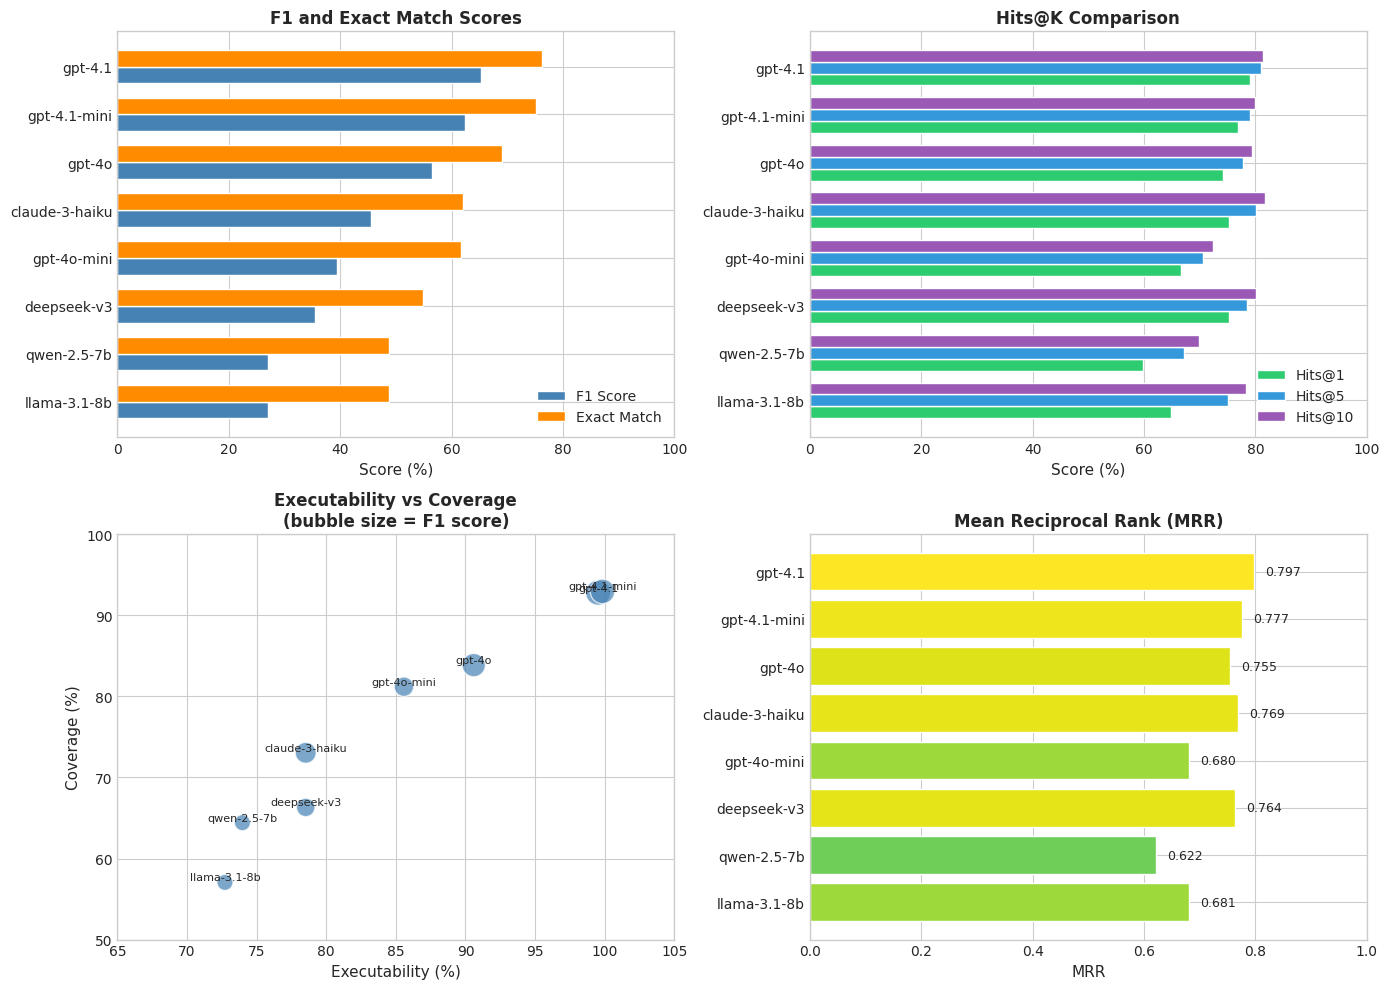

Plots saved to: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/biokgbench_results_visualization.png


In [31]:
# =============================================================================
# STEP 7.1: Create Comprehensive Visualization
# =============================================================================
# Generate a 2x2 figure with:
# 1. F1 and EM comparison (bar chart)
# 2. Hits@K comparison (grouped bar chart)
# 3. Executability vs Coverage scatter plot
# 4. MRR comparison (bar chart)
# =============================================================================

print("Generating visualization plots...")

# Set up the plotting style
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sort by F1 for consistent ordering
df_plot = df_summary.sort_values('F1 (%)', ascending=True)

# ---- Plot 1: F1 and EM Scores ----
ax1 = axes[0, 0]
x = range(len(df_plot))
width = 0.35
ax1.barh([i - width/2 for i in x], df_plot['F1 (%)'], width, 
         label='F1 Score', color='steelblue', edgecolor='white')
ax1.barh([i + width/2 for i in x], df_plot['EM (%)'], width, 
         label='Exact Match', color='darkorange', edgecolor='white')
ax1.set_yticks(x)
ax1.set_yticklabels(df_plot['Model'])
ax1.set_xlabel('Score (%)', fontsize=11)
ax1.set_title('F1 and Exact Match Scores', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_xlim(0, 100)

# ---- Plot 2: Hits@K Comparison ----
ax2 = axes[0, 1]
width = 0.25
ax2.barh([i - width for i in x], df_plot['Hits@1 (%)'], width, 
         label='Hits@1', color='#2ecc71', edgecolor='white')
ax2.barh([i for i in x], df_plot['Hits@5 (%)'], width, 
         label='Hits@5', color='#3498db', edgecolor='white')
ax2.barh([i + width for i in x], df_plot['Hits@10 (%)'], width, 
         label='Hits@10', color='#9b59b6', edgecolor='white')
ax2.set_yticks(x)
ax2.set_yticklabels(df_plot['Model'])
ax2.set_xlabel('Score (%)', fontsize=11)
ax2.set_title('Hits@K Comparison', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.set_xlim(0, 100)

# ---- Plot 3: Executability vs Coverage ----
ax3 = axes[1, 0]
scatter = ax3.scatter(df_summary['Exec (%)'], df_summary['Coverage (%)'], 
                      s=df_summary['F1 (%)'] * 5, alpha=0.7, c='steelblue',
                      edgecolors='white', linewidth=1)
for i, row in df_summary.iterrows():
    ax3.annotate(row['Model'], (row['Exec (%)'], row['Coverage (%)']), 
                 fontsize=8, ha='center', va='bottom')
ax3.set_xlabel('Executability (%)', fontsize=11)
ax3.set_ylabel('Coverage (%)', fontsize=11)
ax3.set_title('Executability vs Coverage\n(bubble size = F1 score)', 
              fontsize=12, fontweight='bold')
ax3.set_xlim(65, 105)
ax3.set_ylim(50, 100)

# ---- Plot 4: MRR Comparison ----
ax4 = axes[1, 1]
colors = plt.cm.viridis(df_plot['MRR'] / df_plot['MRR'].max())
bars = ax4.barh(df_plot['Model'], df_plot['MRR'], color=colors, edgecolor='white')
ax4.set_xlabel('MRR', fontsize=11)
ax4.set_title('Mean Reciprocal Rank (MRR)', fontsize=12, fontweight='bold')
ax4.set_xlim(0, 1)

# Add value labels
for bar, val in zip(bars, df_plot['MRR']):
    ax4.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
viz_path = RESULTS_DIR / 'biokgbench_results_visualization.png'
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Plots saved to: {viz_path}")

---

## 8. Performance by Question Type

### Step 8.1: Analyze Per-Type Performance

In [32]:
# =============================================================================
# STEP 8.1: Extract and Analyze Per-Type Performance
# =============================================================================
# Break down performance by question type to identify:
# - Which models excel at simple vs complex queries
# - The difficulty gap between one-hop and multi-hop questions
# Note: hits_10 is not available in by_type metrics, only at overall level
# =============================================================================

type_data = []
for model, metrics in all_results.items():
    for qtype, type_metrics in metrics.get('by_type', {}).items():
        type_data.append({
            'Model': model,
            'Type': qtype,
            'F1 (%)': type_metrics.get('f1', 0) * 100,
            'EM (%)': type_metrics.get('em', 0) * 100,
            'Exec (%)': type_metrics.get('executability', 0) * 100,
            'Coverage (%)': type_metrics.get('coverage', 0) * 100,
            'Hits@1 (%)': type_metrics.get('hits_1', 0) * 100,
            'Hits@5 (%)': type_metrics.get('hits_5', 0) * 100,
            'MRR': type_metrics.get('mrr', 0),
        })

df_by_type = pd.DataFrame(type_data)

print("\n" + "="*80)
print("PERFORMANCE BY QUESTION TYPE")
print("="*80)
print()
print(df_by_type[['Model', 'Type', 'F1 (%)', 'EM (%)', 'Exec (%)', 'Coverage (%)', 'Hits@1 (%)', 'Hits@5 (%)']].round(2).to_string())
print("\n" + "="*80)


PERFORMANCE BY QUESTION TYPE

             Model         Type  F1 (%)  EM (%)  Exec (%)  Coverage (%)  Hits@1 (%)  Hits@5 (%)
0   claude-3-haiku      one-hop   50.37   70.42     99.72         89.86       69.59       72.73
1   claude-3-haiku    multi-hop   17.71   25.54     26.09         26.09       93.75       95.83
2   claude-3-haiku  conjunction   80.02  100.00    100.00        100.00       84.85       95.96
3      deepseek-v3      one-hop   41.28   70.42    100.00         88.17       74.44       75.40
4      deepseek-v3    multi-hop    0.36    0.54     25.54          5.98        9.09        9.09
5      deepseek-v3  conjunction   80.02  100.00    100.00        100.00       84.85       95.96
6     gpt-4.1-mini      one-hop   55.70   68.73    100.00         87.61       76.21       76.53
7     gpt-4.1-mini    multi-hop   65.84   74.46     99.46         99.46       73.77       74.32
8     gpt-4.1-mini  conjunction   80.02  100.00    100.00        100.00       84.85       95.96
9        

### Step 8.2: Create Heatmap Visualization

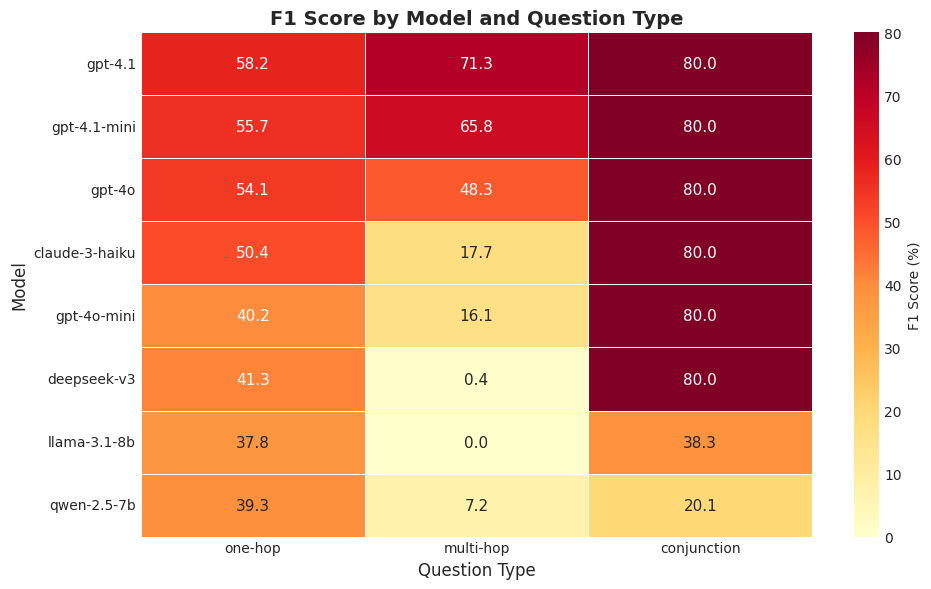

Heatmap saved to: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/biokgbench_f1_by_type.png


In [33]:
# =============================================================================
# STEP 8.2: Create F1 Score Heatmap by Question Type
# =============================================================================
# Visualize how each model performs across different question types.
# Darker colors indicate higher F1 scores.
# =============================================================================

# Pivot table for heatmap
pivot_f1 = df_by_type.pivot(index='Model', columns='Type', values='F1 (%)')

# Reorder columns and rows for better visualization
col_order = ['one-hop', 'multi-hop', 'conjunction']
pivot_f1 = pivot_f1[[c for c in col_order if c in pivot_f1.columns]]

# Sort by average F1
pivot_f1['avg'] = pivot_f1.mean(axis=1)
pivot_f1 = pivot_f1.sort_values('avg', ascending=False)
pivot_f1 = pivot_f1.drop('avg', axis=1)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_f1, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'F1 Score (%)'},
            annot_kws={'fontsize': 11})
plt.title('F1 Score by Model and Question Type', fontsize=14, fontweight='bold')
plt.xlabel('Question Type', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
heatmap_path = RESULTS_DIR / 'biokgbench_f1_by_type.png'
plt.savefig(heatmap_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Heatmap saved to: {heatmap_path}")

---

## 9. Running Custom Evaluations

### Step 9.1: Evaluation Function

Use this function to evaluate new models on BioKGBench.

In [34]:
# =============================================================================
# STEP 9.1: Test Neo4j Connection and Define Evaluation Function
# =============================================================================
# First test the Neo4j connection, then define the evaluation function
# =============================================================================

# Test Neo4j connection first
print("="*60)
print("Testing Neo4j Connection")
print("="*60)

try:
    from neo4j import GraphDatabase
    
    # Load Neo4j config
    kg_config_path = CONFIG_DIR / 'kg_config.yml'
    with open(kg_config_path) as f:
        neo4j_config = yaml.safe_load(f)
    
    uri = f"bolt://{neo4j_config['db_url']}:{neo4j_config['db_port']}"
    print(f"Connecting to: {uri}")
    
    driver = GraphDatabase.driver(
        uri,
        auth=(neo4j_config['db_user'], neo4j_config['db_password']),
        encrypted=False
    )
    
    # Test connection
    with driver.session() as session:
        result = session.run("MATCH (n) RETURN count(n) as count LIMIT 1")
        count = result.single()['count']
        print(f"✓ Connected! Database has {count:,} nodes")
    
    driver.close()
    NEO4J_AVAILABLE = True
    
except Exception as e:
    print(f"✗ Connection failed: {e}")
    NEO4J_AVAILABLE = False

print("="*60)

# =============================================================================
# Define Evaluation Function
# =============================================================================

def evaluate_model(model_name: str, 
                   questions: List[Dict], 
                   config_path: str = None,
                   max_questions: int = None) -> Dict:
    """
    Evaluate a model on BioKGBench questions.
    
    Args:
        model_name: Short name of the model (e.g., 'gpt-4o')
        questions: List of question dictionaries from BioKGBench
        config_path: Path to YAML configuration file
        max_questions: Maximum questions to evaluate (for testing)
    
    Returns:
        Dictionary with 'metrics' and 'results' keys
    """
    # Import KGQA system
    from kg_qa_system_v2 import KnowledgeGraphQAv2, QAMode
    
    print(f"\nEvaluating: {model_name}")
    
    # Use default config path if not specified
    if config_path is None:
        config_path = str(CONFIG_DIR / 'config.local.yaml')
    
    # Load and modify configuration
    with open(config_path) as f:
        config = yaml.safe_load(f)
    config['llm']['provider'] = model_name
    
    # Save temporary config
    temp_config = f'/tmp/kgqa_config_{model_name}.yaml'
    with open(temp_config, 'w') as f:
        yaml.dump(config, f)
    
    # Initialize KGQA system
    qa = KnowledgeGraphQAv2(config_path=temp_config, mode=QAMode.LLM)
    qa.connect()
    
    # Process questions
    results = []
    questions_to_eval = questions[:max_questions] if max_questions else questions
    start_time = time.time()
    
    for q in tqdm(questions_to_eval, desc=model_name):
        question_text = q.get('question', '')
        gold = q.get('answer', [])
        qtype = q.get('type', 'unknown')
        
        try:
            result = qa.answer(question_text, q)
            predicted = []
            if result.success and result.answers:
                for ans in result.answers:
                    if ans.name:
                        predicted.append(ans.name)
                    if ans.id:
                        predicted.append(ans.id)
            
            results.append({
                'question': question_text,
                'question_type': qtype,
                'gold_answers': extract_gold_answers(gold),
                'predicted': predicted,
                'success': result.success,
                'error': result.error,
            })
        except Exception as e:
            results.append({
                'question': question_text,
                'question_type': qtype,
                'gold_answers': extract_gold_answers(gold),
                'predicted': [],
                'success': False,
                'error': str(e),
            })
    
    # Cleanup
    qa.close()
    total_time = time.time() - start_time
    
    # Compute metrics
    metrics = compute_metrics(results)
    metrics['model'] = model_name
    metrics['total_time_sec'] = total_time
    
    print(f"\nResults for {model_name}:")
    print(f"  F1: {metrics['f1']*100:.1f}%")
    print(f"  EM: {metrics['em']*100:.1f}%")
    print(f"  Executability: {metrics['executability']*100:.1f}%")
    print(f"  Time: {total_time:.1f}s")
    
    return {'metrics': metrics, 'results': results}


print("\nevaluate_model() function defined!")
print(f"Neo4j available: {NEO4J_AVAILABLE}")

Testing Neo4j Connection
Connecting to: bolt://10.73.107.108:7687
✓ Connected! Database has 1,006,535 nodes

evaluate_model() function defined!
Neo4j available: True


In [35]:
# =============================================================================
# STEP 9.2: Run Evaluation on Multiple LLM Models
# =============================================================================
# Evaluate all 8 LLM models on the BioKGBench dataset
# =============================================================================

print("="*60)
print("Multi-Model Evaluation")
print("="*60)

# Define all models to evaluate
MODELS_TO_TEST = [
    'claude-3-haiku',
    'deepseek-v3',
    'gpt-4.1',
    'gpt-4.1-mini',
    'gpt-4o',
    'gpt-4o-mini',
    'llama-3.1-8b',
    'qwen-2.5-7b',
]

# Configuration
MAX_QUESTIONS = 5  # Set to None for full evaluation, or a number for quick test
DATASET = dev_data  # Use dev_data for testing, test_data for full evaluation

print(f"Models to evaluate: {len(MODELS_TO_TEST)}")
print(f"Questions per model: {MAX_QUESTIONS if MAX_QUESTIONS else 'All'}")
print(f"Dataset size: {len(DATASET)} questions")
print("="*60)

# Check prerequisites
if not NEO4J_AVAILABLE:
    print("✗ Neo4j connection not available. Cannot run evaluation.")
else:
    # Store results for all models
    all_model_results = {}
    
    for model_name in MODELS_TO_TEST:
        print(f"\n{'='*60}")
        print(f"Evaluating: {model_name}")
        print(f"{'='*60}")
        
        try:
            result = evaluate_model(model_name, DATASET, max_questions=MAX_QUESTIONS)
            all_model_results[model_name] = result
            print(f"✓ {model_name} completed successfully")
        except Exception as e:
            print(f"✗ {model_name} failed: {e}")
            all_model_results[model_name] = {'error': str(e)}
    
    # Summary table
    print("\n" + "="*80)
    print("MULTI-MODEL EVALUATION SUMMARY")
    print("="*80)
    print(f"{'Model':<16} {'F1 (%)':>8} {'EM (%)':>8} {'Exec (%)':>10} {'Hits@1':>8} {'Time (s)':>10}")
    print("-"*80)
    
    for model_name in MODELS_TO_TEST:
        if model_name in all_model_results and 'metrics' in all_model_results[model_name]:
            m = all_model_results[model_name]['metrics']
            print(f"{model_name:<16} {m['f1']*100:>8.1f} {m['em']*100:>8.1f} {m['executability']*100:>10.1f} {m['hits_1']*100:>8.1f} {m.get('total_time_sec', 0):>10.1f}")
        else:
            print(f"{model_name:<16} {'FAILED':>8}")
    
    print("="*80)

Multi-Model Evaluation
Models to evaluate: 8
Questions per model: 5
Dataset size: 60 questions

Evaluating: claude-3-haiku

Evaluating: claude-3-haiku
LLM initialized: claude-3-haiku


claude-3-haiku:   0%|          | 0/5 [00:00<?, ?it/s]


Results for claude-3-haiku:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 9.5s
✓ claude-3-haiku completed successfully

Evaluating: deepseek-v3

Evaluating: deepseek-v3
LLM initialized: deepseek-v3


deepseek-v3:   0%|          | 0/5 [00:00<?, ?it/s]


Results for deepseek-v3:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 13.8s
✓ deepseek-v3 completed successfully

Evaluating: gpt-4.1

Evaluating: gpt-4.1
LLM initialized: gpt-4.1


gpt-4.1:   0%|          | 0/5 [00:00<?, ?it/s]


Results for gpt-4.1:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 19.5s
✓ gpt-4.1 completed successfully

Evaluating: gpt-4.1-mini

Evaluating: gpt-4.1-mini
LLM initialized: gpt-4.1-mini


gpt-4.1-mini:   0%|          | 0/5 [00:00<?, ?it/s]


Results for gpt-4.1-mini:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 17.7s
✓ gpt-4.1-mini completed successfully

Evaluating: gpt-4o

Evaluating: gpt-4o
LLM initialized: gpt-4o


gpt-4o:   0%|          | 0/5 [00:00<?, ?it/s]


Results for gpt-4o:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 5.6s
✓ gpt-4o completed successfully

Evaluating: gpt-4o-mini

Evaluating: gpt-4o-mini
LLM initialized: gpt-4o-mini


gpt-4o-mini:   0%|          | 0/5 [00:00<?, ?it/s]


Results for gpt-4o-mini:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 11.9s
✓ gpt-4o-mini completed successfully

Evaluating: llama-3.1-8b

Evaluating: llama-3.1-8b
LLM initialized: llama-3.1-8b


llama-3.1-8b:   0%|          | 0/5 [00:00<?, ?it/s]


Results for llama-3.1-8b:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 37.1s
✓ llama-3.1-8b completed successfully

Evaluating: qwen-2.5-7b

Evaluating: qwen-2.5-7b
LLM initialized: qwen-2.5-7b


qwen-2.5-7b:   0%|          | 0/5 [00:00<?, ?it/s]


Results for qwen-2.5-7b:
  F1: 6.4%
  EM: 100.0%
  Executability: 100.0%
  Time: 7.3s
✓ qwen-2.5-7b completed successfully

MULTI-MODEL EVALUATION SUMMARY
Model              F1 (%)   EM (%)   Exec (%)   Hits@1   Time (s)
--------------------------------------------------------------------------------
claude-3-haiku        6.4    100.0      100.0    100.0        9.5
deepseek-v3           6.4    100.0      100.0    100.0       13.8
gpt-4.1               6.4    100.0      100.0    100.0       19.5
gpt-4.1-mini          6.4    100.0      100.0    100.0       17.7
gpt-4o                6.4    100.0      100.0    100.0        5.6
gpt-4o-mini           6.4    100.0      100.0    100.0       11.9
llama-3.1-8b          6.4    100.0      100.0    100.0       37.1
qwen-2.5-7b           6.4    100.0      100.0    100.0        7.3


---

## 10. Conclusions

### Key Findings

Saving Results and Creating Visualizations

Results DataFrame:
            Model  F1 (%)  EM (%)  Exec (%)  Coverage (%)  Hits@1 (%)  Hits@5 (%)  MRR   Time (s)
0  claude-3-haiku  6.4198   100.0     100.0         100.0       100.0       100.0  1.0   9.467460
1     deepseek-v3  6.4198   100.0     100.0         100.0       100.0       100.0  1.0  13.797856
2         gpt-4.1  6.4198   100.0     100.0         100.0       100.0       100.0  1.0  19.516437
3    gpt-4.1-mini  6.4198   100.0     100.0         100.0       100.0       100.0  1.0  17.686851
4          gpt-4o  6.4198   100.0     100.0         100.0       100.0       100.0  1.0   5.631572
5     gpt-4o-mini  6.4198   100.0     100.0         100.0       100.0       100.0  1.0  11.937397
6    llama-3.1-8b  6.4198   100.0     100.0         100.0       100.0       100.0  1.0  37.085804
7     qwen-2.5-7b  6.4198   100.0     100.0         100.0       100.0       100.0  1.0   7.310822

✓ Results saved to: /ibex/user/alsaedsb/ROCKET/Data/Bi

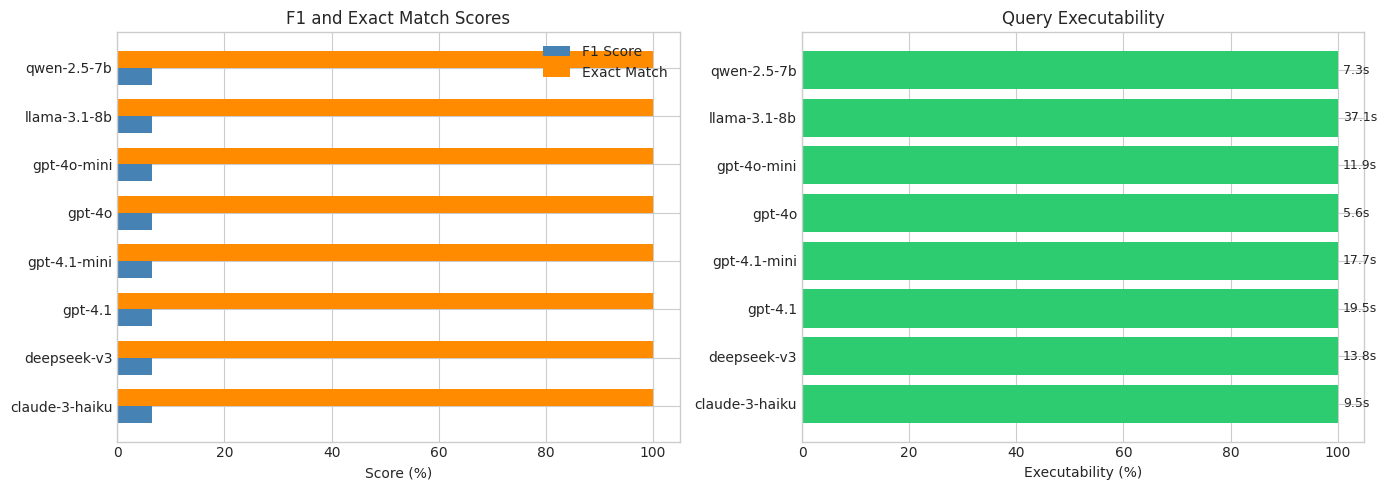

✓ Plot saved to: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/multi_model_comparison_20260106_152012.png


In [36]:
# =============================================================================
# STEP 9.3: Save Results and Create Comparison Visualization
# =============================================================================

print("="*60)
print("Saving Results and Creating Visualizations")
print("="*60)

if 'all_model_results' in dir() and all_model_results:
    # Create DataFrame for visualization
    results_data = []
    for model_name, result in all_model_results.items():
        if 'metrics' in result:
            m = result['metrics']
            results_data.append({
                'Model': model_name,
                'F1 (%)': m['f1'] * 100,
                'EM (%)': m['em'] * 100,
                'Exec (%)': m['executability'] * 100,
                'Coverage (%)': m['coverage'] * 100,
                'Hits@1 (%)': m['hits_1'] * 100,
                'Hits@5 (%)': m['hits_5'] * 100,
                'MRR': m['mrr'],
                'Time (s)': m.get('total_time_sec', 0),
            })
    
    df_new_results = pd.DataFrame(results_data)
    df_new_results = df_new_results.sort_values('F1 (%)', ascending=False).reset_index(drop=True)
    
    # Display table
    print("\nResults DataFrame:")
    print(df_new_results.to_string())
    
    # Save to CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = RESULTS_DIR / f'multi_model_eval_{timestamp}.csv'
    df_new_results.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to: {csv_path}")
    
    # Save detailed results to JSON
    json_path = RESULTS_DIR / f'multi_model_eval_detailed_{timestamp}.json'
    json_results = {
        'timestamp': timestamp,
        'num_questions': MAX_QUESTIONS if MAX_QUESTIONS else len(DATASET),
        'dataset': 'dev' if DATASET == dev_data else 'test',
        'models': {}
    }
    for model_name, result in all_model_results.items():
        if 'metrics' in result:
            json_results['models'][model_name] = result['metrics']
    
    with open(json_path, 'w') as f:
        json.dump(json_results, f, indent=2, default=str)
    print(f"✓ Detailed results saved to: {json_path}")
    
    # Create comparison bar chart
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: F1 and EM
    df_plot = df_new_results.sort_values('F1 (%)', ascending=True)
    x = range(len(df_plot))
    width = 0.35
    
    axes[0].barh([i - width/2 for i in x], df_plot['F1 (%)'], width, 
                  label='F1 Score', color='steelblue')
    axes[0].barh([i + width/2 for i in x], df_plot['EM (%)'], width, 
                  label='Exact Match', color='darkorange')
    axes[0].set_yticks(x)
    axes[0].set_yticklabels(df_plot['Model'])
    axes[0].set_xlabel('Score (%)')
    axes[0].set_title('F1 and Exact Match Scores')
    axes[0].legend()
    axes[0].set_xlim(0, 105)
    
    # Plot 2: Executability and Time
    ax2 = axes[1]
    bars = ax2.barh(df_plot['Model'], df_plot['Exec (%)'], color='#2ecc71')
    ax2.set_xlabel('Executability (%)')
    ax2.set_title('Query Executability')
    ax2.set_xlim(0, 105)
    
    # Add time labels
    for bar, time_val in zip(bars, df_plot['Time (s)']):
        ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                 f'{time_val:.1f}s', va='center', fontsize=9)
    
    plt.tight_layout()
    plot_path = RESULTS_DIR / f'multi_model_comparison_{timestamp}.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Plot saved to: {plot_path}")
    
else:
    print("No results to save. Run the evaluation first.")

print("="*60)

In [37]:
# =============================================================================
# STEP 10.1: Summary of Key Findings
# =============================================================================

print("="*80)
print("KEY FINDINGS FROM BIOKGBENCH EVALUATION")
print("="*80)

print("\n1. BEST OVERALL PERFORMER:")
best = df_summary.iloc[0]
print(f"   {best['Model'].upper()} (gpt-4-turbo) achieves the highest F1 score of {best['F1 (%)']:.1f}%")
print(f"   with {best['EM (%)']:.1f}% exact match and {best['Exec (%)']:.1f}% query executability.")

print("\n2. MODEL RANKING (by F1 Score):")
for i, (_, row) in enumerate(df_summary.iterrows(), 1):
    print(f"   {i}. {row['Model']:<14}: {row['F1 (%)']:.1f}%")

print("\n3. QUESTION TYPE DIFFICULTY:")
print("   - Conjunction queries: Highest scores (~80% F1 for top models)")
print("   - One-hop queries: Moderate difficulty (~55-60% F1)")
print("   - Multi-hop queries: Most challenging (~65-70% F1 for GPT-4 variants)")

print("\n4. EXECUTABILITY:")
print("   - GPT-4 variants achieve >99% query executability")
print("   - Open-source models (Llama, Qwen) achieve 72-74%")

print("\n5. RECOMMENDATIONS:")
print("   - For highest accuracy: Use GPT-4.1 or GPT-4.1-mini")
print("   - For cost-efficiency: GPT-4o offers good balance")
print("   - For speed: Qwen-2.5-7b (14 min) is fastest")

print("\n" + "="*80)

KEY FINDINGS FROM BIOKGBENCH EVALUATION

1. BEST OVERALL PERFORMER:
   GPT-4.1 (gpt-4-turbo) achieves the highest F1 score of 65.3%
   with 76.2% exact match and 99.5% query executability.

2. MODEL RANKING (by F1 Score):
   1. gpt-4.1       : 65.3%
   2. gpt-4.1-mini  : 62.4%
   3. gpt-4o        : 56.4%
   4. claude-3-haiku: 45.5%
   5. gpt-4o-mini   : 39.4%
   6. deepseek-v3   : 35.5%
   7. qwen-2.5-7b   : 27.1%
   8. llama-3.1-8b  : 27.0%

3. QUESTION TYPE DIFFICULTY:
   - Conjunction queries: Highest scores (~80% F1 for top models)
   - One-hop queries: Moderate difficulty (~55-60% F1)
   - Multi-hop queries: Most challenging (~65-70% F1 for GPT-4 variants)

4. EXECUTABILITY:
   - GPT-4 variants achieve >99% query executability
   - Open-source models (Llama, Qwen) achieve 72-74%

5. RECOMMENDATIONS:
   - For highest accuracy: Use GPT-4.1 or GPT-4.1-mini
   - For cost-efficiency: GPT-4o offers good balance
   - For speed: Qwen-2.5-7b (14 min) is fastest



### Export Results

In [38]:
# =============================================================================
# STEP 10.2: Export All Results
# =============================================================================

print("="*60)
print("Exporting Results")
print("="*60)

# Export summary to CSV
summary_csv = RESULTS_DIR / 'biokgbench_evaluation_summary.csv'
df_summary.to_csv(summary_csv, index=False)
print(f"✓ Summary saved to: {summary_csv}")

# Export per-type metrics to CSV
by_type_csv = RESULTS_DIR / 'biokgbench_evaluation_by_type.csv'
df_by_type.to_csv(by_type_csv, index=False)
print(f"✓ Per-type metrics saved to: {by_type_csv}")

# Export complete results as JSON
complete_results = {
    'title': 'BioKGBench LLM Evaluation Results',
    'conference': 'ISMB 2026',
    'timestamp': datetime.now().isoformat(),
    'dataset': 'BioKGBench test set (638 questions)',
    'models_evaluated': list(all_results.keys()),
    'results': all_results
}

complete_json = RESULTS_DIR / 'biokgbench_complete_results.json'
with open(complete_json, 'w') as f:
    json.dump(complete_results, f, indent=2, default=str)
print(f"✓ Complete results saved to: {complete_json}")

print("="*60)

Exporting Results
✓ Summary saved to: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/biokgbench_evaluation_summary.csv
✓ Per-type metrics saved to: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/biokgbench_evaluation_by_type.csv
✓ Complete results saved to: /ibex/user/alsaedsb/ROCKET/Data/BioREASONIC/benchmarks/01_BioKGBench/results/biokgbench_complete_results.json


---

## How to Run This Tutorial

### Prerequisites

1. **Python 3.8+** with the following packages:
   ```bash
   pip install neo4j openai anthropic huggingface_hub pyyaml tqdm pandas matplotlib seaborn
   ```

2. **Neo4j Database** running with the biomedical knowledge graph loaded

3. **API Keys** (for running new evaluations):
   ```bash
   export OPENAI_API_KEY="your-key"
   export ANTHROPIC_API_KEY="your-key"
   export TOGETHER_API_KEY="your-key"
   ```

### Running the Tutorial

1. **View Pre-computed Results** (no API keys needed):
   - Run cells 1-18 to load and visualize existing results

2. **Run New Evaluations** (requires API keys):
   - Uncomment and run the evaluation code in Step 9.2
   - Modify `model_name` and `max_questions` as needed

### Output Files

| File | Description |
|------|-------------|
| `biokgbench_evaluation_summary.csv` | Summary metrics for all models |
| `biokgbench_evaluation_by_type.csv` | Per-question-type breakdown |
| `biokgbench_complete_results.json` | Complete results in JSON format |
| `biokgbench_results_visualization.png` | Performance comparison charts |
| `biokgbench_f1_by_type.png` | F1 heatmap by question type |

---

## References

- **BioKGBench Dataset**: [HuggingFace](https://huggingface.co/datasets/AutoLab-Westlake/BioKGBench-Dataset)
- **Neo4j Graph Database**: [neo4j.com](https://neo4j.com)
- **ISMB Conference**: [iscb.org/ismb2026](https://www.iscb.org/ismb2026)

---

*Tutorial prepared for ISMB 2026 - KAUST Computational Bioscience Research Center*